In [1]:
# import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
# from tqdm.rich import tqdm, trange
from tqdm import tqdm, trange

import seaborn as sns
import matplotlib.pylab as plt

from emd import emd_pot
from data_loader import get_database_path, get_h5_files, read_h5_file
np.random.seed(114514)

In [2]:
def sample_pairs(n_events, n_pairs):
    pairs = np.zeros((n_pairs, 2), dtype=int)
    for i in trange(n_pairs):
        pairs[i] = np.random.choice(n_events, 2, replace=False)
    return pairs

def sample_matrix(n_events, pairs):
    matrix = np.zeros((n_events, n_events))
    for pair in pairs:
        matrix[pair[0], pair[1]] += 1
    return matrix

100%|██████████| 2000/2000 [00:00<00:00, 70173.48it/s]


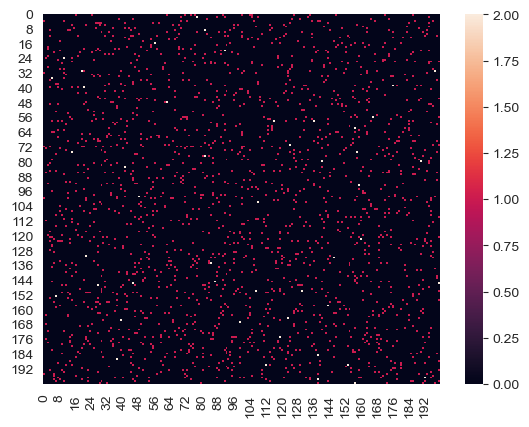

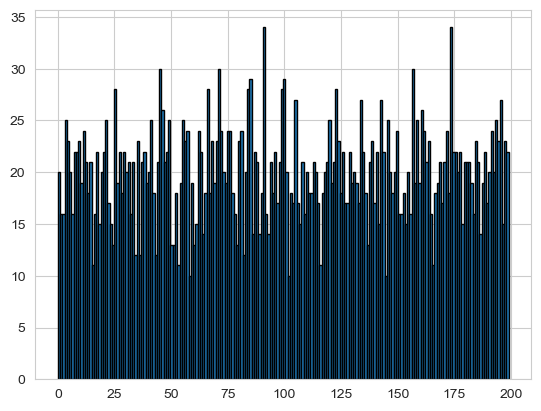

In [3]:
test_n_events = 200
test_n_pairs = 2000
test_pairs = sample_pairs(test_n_events, test_n_pairs)
test_matrix = sample_matrix(test_n_events, test_pairs)
ax = sns.heatmap(test_matrix)
plt.show()
plt.hist(test_pairs.flatten(), bins=test_n_events, edgecolor='black')
plt.show()

In [4]:
def sample_pairs_with_emd(events, n_pairs):
    n_events = len(events)
    pairs = np.zeros((n_pairs, 2), dtype=int)
    emds = np.zeros(n_pairs)
    for i in trange(n_pairs):
        pairs[i] = np.random.choice(n_events, 2, replace=False)
        emds[i] = emd_pot(events[pairs[i][0]], events[pairs[i][1]])
    return pairs, emds

In [7]:
class PairedEventsDataset(Dataset):
    def __init__(self, events, n_pairs=None):
        self.events = events
        self.n_events = len(events)
        if n_pairs is None:
            n_pairs = 5 * len(events)
        self.pairs = sample_pairs(self.n_events, n_pairs)
        self.emds = np.zeros(len(self.pairs))
        for i, pair in enumerate(tqdm(self.pairs)):
            self.emds[i] = emd_pot(events[pair[0]], events[pair[1]])
        
    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        return self.events[self.pairs[idx][0]], self.events[self.pairs[idx][1]], self.emds[idx]
        

In [8]:
database_path = get_database_path()
bkg_files, sig_files = get_h5_files()

bkg = read_h5_file(database_path, bkg_files[0]['file'])['Particles']
neutral_boson = read_h5_file(database_path, sig_files[0]['file'])['Particles']

In [9]:
bkg_dataset = PairedEventsDataset(neutral_boson)

 14%|█▎        | 37927/279845 [04:58<31:44, 127.04it/s]


KeyboardInterrupt: 